In [21]:
# NOTE: This example is very similar to the https://www.tensorflow.org/tutorials/keras/regression tutorial. Check out that tutorial for more information regression being applied to a different dataset.
# Importing Libaries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [10]:
# Import the data
concreteData = pd.read_csv("./concrete_data.csv")

# Print out some data.
concreteData

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [11]:
# Check to make sure that there are no n/a rows
concreteData.isna().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

In [12]:
# Create the training/validation split.
trainingSet = concreteData.sample(frac=0.8, random_state=0)
validationSet = concreteData.drop(trainingSet.index)

In [16]:
# Take a look at the training set.
trainingSet.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Cement,824.0,280.272694,104.483467,102.00,193.125,266.000,350.0000,540.0
Blast Furnace Slag,824.0,73.171238,85.865727,0.00,0.000,22.000,142.5000,359.4
Fly Ash,824.0,55.318325,64.098118,0.00,0.000,0.000,118.3000,200.1
Water,824.0,182.029490,21.287699,121.80,164.900,185.700,192.0000,247.0
Superplasticizer,824.0,6.147816,6.000795,0.00,0.000,6.100,10.1250,32.2
Coarse Aggregate,824.0,973.991019,77.755840,801.00,932.000,968.000,1030.2500,1145.0
Fine Aggregate,824.0,771.898301,80.031529,594.00,721.750,779.300,824.0000,992.6
Age,824.0,45.708738,63.603343,1.00,7.000,28.000,56.0000,365.0
Strength,824.0,35.739478,16.582095,2.33,23.520,34.425,46.2075,82.6


In [17]:
# Now we need to designate what is the label and what are the features that we are predicting.
trainingFeatures = trainingSet.copy()
trainingFeatures.pop("Strength")

validationFeatures = validationSet.copy()
validationFeatures.pop("Strength")

11      28.02
19      42.62
23      44.21
25      53.30
28      37.43
        ...  
999     15.57
1003    65.91
1014    33.31
1018    37.27
1021    31.88
Name: Strength, Length: 206, dtype: float64

In [25]:
# Something we didn't talk about fully is called normalization. This is scaling the data that way the values of the points become what is called a z-score. This allows for the model to convege more easily.
# for more information, check out https://en.wikipedia.org/wiki/Feature_scaling

# We are going to rely on keras to do the heavy lifiting for this.
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(trainingFeatures))

In [104]:
# Here, we define the structure of the neural network. In this case we are going to go input -> normalizer -> 2 hidden layers with 64 neurons and the ReLU activation function -> output layer. 
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

# Now, we are going to compile the model, and tell it the type of loss to look at
# It is important to note that the Adam optimizer is an improve (but more complicated) version of the stochastic gradient decent we looked a during the presentation. For now, just know that it does essentially the same job as SGD.
# Although we talked about mean squared error, sometimes the "square" part means that it listens to outliers too much. In order to prevent this, I decided to use mean_absolute_error which takes the absolute value of the error
# instead of squaring it.
model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))

In [95]:
# We can get a summary of this model that we just created
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 8)                 17        
_________________________________________________________________
dense_19 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 13,138
Trainable params: 13,121
Non-trainable params: 17
_________________________________________________

In [90]:
## A function to plot the loss with matplotlib.. don't worry about this.
def plot_loss(history):
  plt.plot(history.history['loss'], label='Loss')
  plt.plot(history.history['val_loss'], label='Epoch Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

In [105]:
# Now, we can train the model to get it to become accurate.
history = model.fit(trainingFeatures, trainingSet["Strength"], epochs=100, validation_split=0.2, verbose=0)

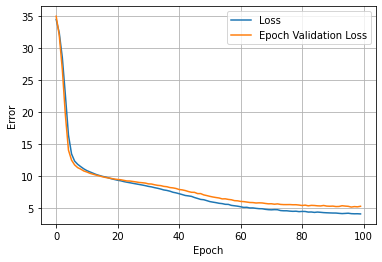

In [106]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plot_loss(history)

In [67]:
# Now that we have a model, which seems to be pretty good at predicting concrete strengh, lets test it to make sure that it didn't overfit!
# We can see that because the loss is about the smae as what we were getting on the data it was trained on, overfitting does not appear to be a signficant issue
model.evaluate(validationFeatures, validationSet["Strength"])

7/7 [==============================] - 0s 1ms/step - loss: 5.1578


5.157785892486572

In [72]:
# Now, lets take a look at the predictions
validationSet['Predictions'] = model.predict(validationFeatures)
validationSet['loss'] = abs(validationSet['Predictions']-validationSet["Strength"]) 

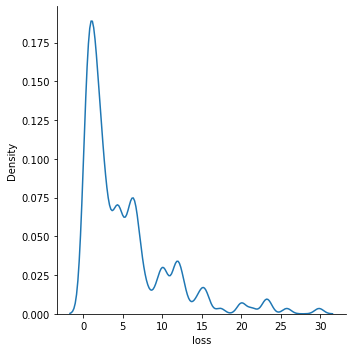

In [82]:
sns.displot(validationSet, x="loss", kind="kde", bw_adjust=0.3)

# Improvements
Models can always improve from changing the number of layers present to changing the number of neurons in each layer. This is by no means the optimal model for concrete prediction, but it is a good example of the power of machine learning and how even with a basic model, and a few layers, you can start getting quite accurate predictions. 